In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torchsummaryX import summary
import numpy as np
import matplotlib.pyplot as plt

In [15]:
# PyTorch 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, num_classes)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)

        x = lstm_out[:, -1, :]
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        # h_0 = torch.zeros(1, x.size(0), 64).to(x.device)  # 초기 hidden state
        # c_0 = torch.zeros(1, x.size(0), 64).to(x.device)  # 초기 cell state
        
        # # LSTM layer
        # out, _ = self.lstm(x, (h_0, c_0))  # 전체 시퀀스에 대한 출력
        # out = self.fc(out[:, -1, :])  # 마지막 타임스텝의 결과만 사용
        return x

In [16]:
# Hyperparameters
timesteps = 30
features = 99
num_classes = 3
batch_size = 32
epochs = 200
learning_rate = 0.001

In [17]:
# 액션 리스트
actions = ['click', 'stanby1', 'stanby2']

# 데이터 로드
data = np.concatenate([
    np.load('dataset/seq_click_1727661194.npy'),
    np.load('dataset/seq_stanby1_1727661194.npy'),
    np.load('dataset/seq_stanby2_1727661194.npy')
], axis=0)

# 입력 데이터 (x_data)와 라벨 (labels) 분리
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

# Tensor로 변환
x_data = x_data.astype(np.float32)  # 입력 데이터를 float32로 변환
labels = labels.astype(np.int64)    # 라벨 데이터를 int64로 변환 (PyTorch에서는 Long 타입 필요)

# 학습용 데이터와 검증용 데이터 분리
x_train, x_val, y_train, y_val = train_test_split(x_data, labels, test_size=0.1, random_state=42)

# PyTorch Tensor로 변환
x_train_tensor = torch.tensor(x_train)
y_train_tensor = torch.tensor(y_train)
x_val_tensor = torch.tensor(x_val)
y_val_tensor = torch.tensor(y_val)

# TensorDataset을 사용해 PyTorch 데이터셋 생성
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

# DataLoader로 데이터셋을 배치 단위로 처리
batch_size = 32
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

# DataLoader가 정상적으로 준비되었는지 확인
for x_batch, y_batch in train_loader:
    print(f"x_batch: {x_batch.shape}, y_batch: {y_batch.shape}")
    break

x_batch: torch.Size([32, 30, 99]), y_batch: torch.Size([32])


In [18]:
# 모델, 손실 함수, 옵티마이저 정의
model = LSTMModel(input_size=features, hidden_size=64, num_classes=num_classes).to('mps' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [19]:
# 학습 루프
device = torch.device('mps' if torch.cuda.is_available() else 'cpu')
model.to(device)

LSTMModel(
  (lstm): LSTM(99, 64, batch_first=True)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=3, bias=True)
)

In [20]:
summary(model, torch.zeros((1,30,99)))

----------------------------------------------------------------------------------------------------
Layer                   Kernel Shape         Output Shape         # Params (K)      # Mult-Adds (M)
0_LSTM                             -          [1, 30, 64]                42.24                 0.04
  weight_ih_l0             [256, 99]
  weight_hh_l0             [256, 64]
1_Linear                    [64, 32]              [1, 32]                 2.08                 0.00
2_Linear                    [32, 32]              [1, 32]                 1.06                 0.00
3_Linear                     [32, 3]               [1, 3]                 0.10                 0.00
# Params:    45.48K
# Mult-Adds: 0.04M
----------------------------------------------------------------------------------------------------


In [21]:
# 에폭당 정확도와 손실을 저장할 리스트
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Training loop
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Optimizer 초기화
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Loss 및 accuracy 기록
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # 에폭당 평균 학습 손실과 정확도 계산
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total

    train_loss_list.append(epoch_loss)
    train_acc_list.append(epoch_acc)

    # Validation loop
    model.eval()  # 검증 중에는 dropout 등을 끄기 위해서 eval 모드로 전환
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():  # 검증 시에는 gradient를 계산하지 않음
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)

            # Loss 및 accuracy 기록
            val_running_loss += val_loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    # 에폭당 평균 검증 손실과 정확도 계산
    val_epoch_loss = val_running_loss / len(val_loader)
    val_epoch_acc = 100 * val_correct / val_total

    val_loss_list.append(val_epoch_loss)
    val_acc_list.append(val_epoch_acc)

    # 학습 및 검증 결과 출력
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%, "
          f"Val Loss: {val_epoch_loss:.4f}, Val Accuracy: {val_epoch_acc:.2f}%")

# 모델 저장
torch.save(model.state_dict(), 'models/lstm_model.pth')
print("모델 저장 완료")

Epoch [1/200], Loss: 0.9577, Accuracy: 69.79%, Val Loss: 0.7440, Val Accuracy: 89.47%
Epoch [2/200], Loss: 0.6722, Accuracy: 88.99%, Val Loss: 0.6197, Val Accuracy: 93.16%
Epoch [3/200], Loss: 0.6107, Accuracy: 94.96%, Val Loss: 0.5883, Val Accuracy: 97.37%
Epoch [4/200], Loss: 0.5828, Accuracy: 98.13%, Val Loss: 0.5711, Val Accuracy: 98.95%
Epoch [5/200], Loss: 0.5655, Accuracy: 99.53%, Val Loss: 0.5679, Val Accuracy: 98.95%
Epoch [6/200], Loss: 0.5653, Accuracy: 99.12%, Val Loss: 0.5636, Val Accuracy: 99.47%
Epoch [7/200], Loss: 0.5588, Accuracy: 99.71%, Val Loss: 0.5561, Val Accuracy: 100.00%
Epoch [8/200], Loss: 0.5555, Accuracy: 99.88%, Val Loss: 0.5544, Val Accuracy: 100.00%
Epoch [9/200], Loss: 0.5556, Accuracy: 99.77%, Val Loss: 0.5796, Val Accuracy: 97.89%
Epoch [10/200], Loss: 0.5568, Accuracy: 99.71%, Val Loss: 0.5535, Val Accuracy: 100.00%
Epoch [11/200], Loss: 0.5523, Accuracy: 100.00%, Val Loss: 0.5524, Val Accuracy: 100.00%
Epoch [12/200], Loss: 0.5520, Accuracy: 100.00%

In [23]:
model_scripted = torch.jit.script(model)
model_scripted.save('lstm_model_scr.pt')

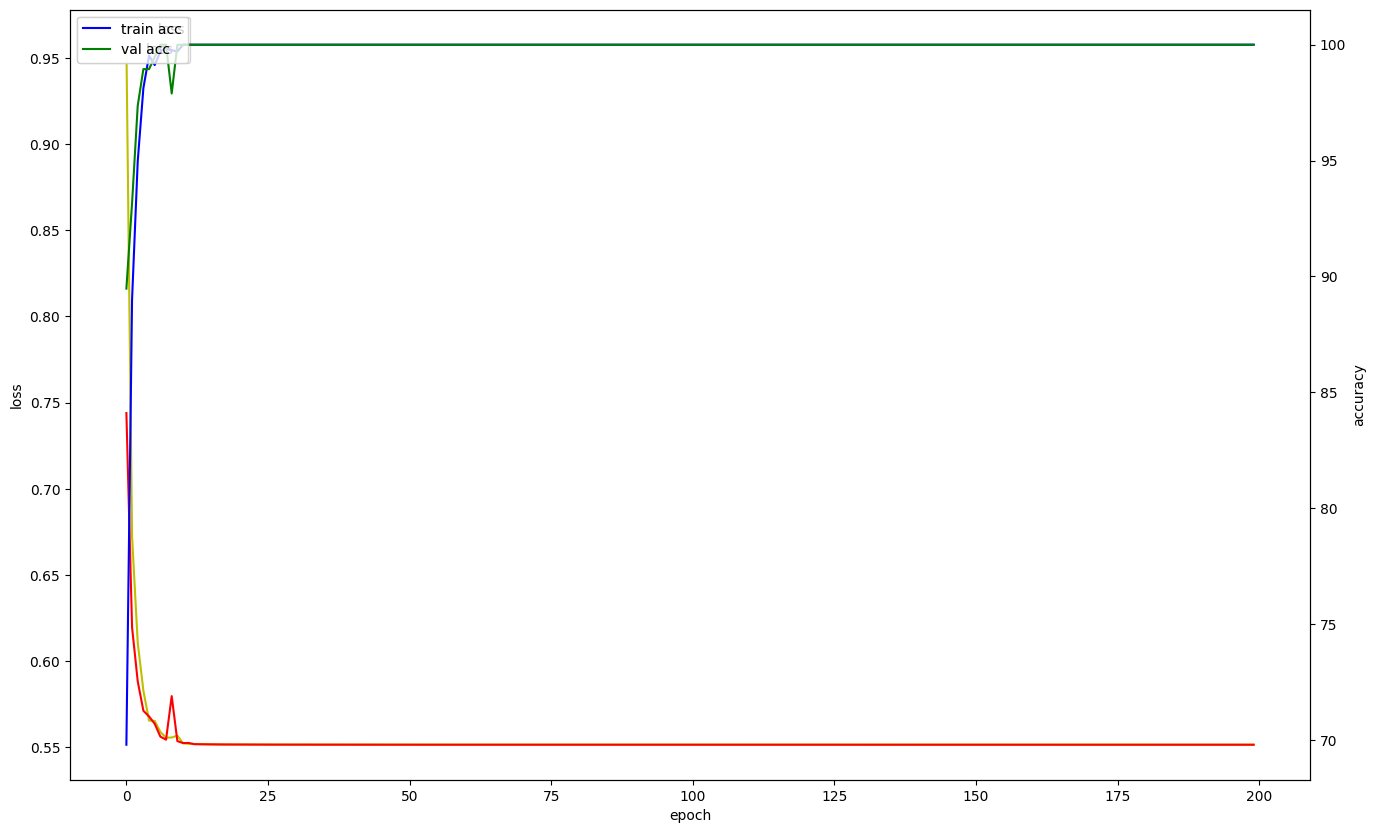

In [22]:
fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(train_loss_list, 'y', label='train loss')
loss_ax.plot(val_loss_list, 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(train_acc_list, 'b', label='train acc')
acc_ax.plot(val_acc_list, 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()